# Importing

## Importing modules

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense

from keras.optimizers import SGD, adam, adagrad, rmsprop


## importing own code

In [25]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [26]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split = validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [27]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)

In [28]:
def makeNetwork(inputSize, settings, learningRate, lossFunction='MAE', kernalInitializer='he_uniform'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3]))#, kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3]))#, kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [29]:
filename = 'combinedDataPrepared'#'combinedDataPrepared'
orderOfMatrix = False# Make a list if you want to do the calculations yourself and make a other type of you want to import it

if (type(orderOfMatrix) == list):
    dataRaw = pd.read_json(filename + '.json', orient='columns')
    dataRaw['particleCoordinates'] = dataRaw['particleCoordinates'].apply(np.array)
    data = prepareDatabseForMachineLearningMultiprocessing(dataRaw, orderOfMatrix, filename + 'Prepared', amountOfCores)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
else:
    data = pd.read_json(filename + '.json', orient='columns')
    data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
    #data['eigenvalues'] = data['eigenvalues'].apply(list)

In [30]:
#data.head()

In [31]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,400000.000000,400000.000000,400000.0,4.000000e+05
mean,199999.500000,25.502021,4.0,3.881788e+13
std,115470.198175,14.131364,0.0,2.158445e+16
min,0.000000,1.000059,4.0,-5.304560e-02
25%,99999.750000,13.274154,4.0,-2.860000e-08
50%,199999.500000,25.528924,4.0,1.583500e-07
75%,299999.250000,37.725092,4.0,4.891216e-04
max,399999.000000,49.999906,4.0,1.357338e+19


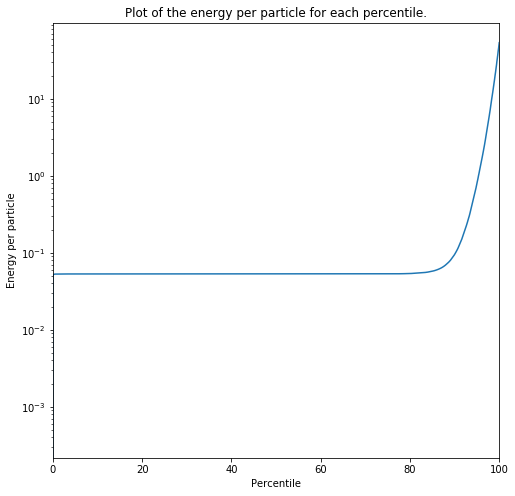

In [32]:
offset=min(data['potentialEnergy'])
data['potentialEnergy'] = data['potentialEnergy']-offset
#qLow = data['potentialEnergy'].quantile(0.00001)
qHi  = data['potentialEnergy'].quantile(0.95)
dataFiltered = data[(data['potentialEnergy'] < qHi)]# & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

data = dataFiltered

In [33]:
#data.head()

In [34]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,380000.000000,380000.000000,380000.0,380000.000000
mean,200002.884639,26.579486,4.0,0.592021
std,115494.287323,13.588725,0.0,3.623477
min,0.000000,1.167091,4.0,0.000000
25%,99953.750000,14.947339,4.0,0.053046
50%,200003.500000,26.706441,4.0,0.053046
75%,300054.250000,38.317992,4.0,0.053181
max,399999.000000,49.999906,4.0,53.335290


In [35]:
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])
    targetData.append(trainingData['potentialEnergy'][i])

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]

# Machine learning

## Preparing testing

In [36]:
widthOfCell = 10.0
numberOfSurroundingCells = 4
R0=100
orderOfMatrix = [-1, 2]
x = np.linspace(0, 1, 80)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.3, 0.5]), np.array([0.9, 0.9]), np.array([0.6, 0.4]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio))# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

testData.head()
testData.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,80.0000,80.0,80.0,80.000000
mean,39.5000,10.0,4.0,0.006196
std,23.2379,0.0,0.0,0.015219
min,0.0000,10.0,4.0,-0.000035
25%,19.7500,10.0,4.0,-0.000033
50%,39.5000,10.0,4.0,-0.000012
75%,59.2500,10.0,4.0,0.001342
max,79.0000,10.0,4.0,0.063472


## Model 1

In [37]:
inputSize = 8
settings = [['Dense', 512, 'softplus', False], ['Dense', 512, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               4096      
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262144    
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 512       
_________________________________________________________________
activation_19 (Activation)   (None, 1)                 0         
Total params: 266,752
Trainable params: 266,752
Non-trainable params: 0
________________________________________________

Train on 212800 samples, validate on 91200 samples
Epoch 1/30
212800/212800 [==============================] - 18s 83us/step - loss: 20.5307 - val_loss: 1.2907
Epoch 2/30
212800/212800 [==============================] - 19s 88us/step - loss: 0.5976 - val_loss: 0.4205
Epoch 3/30
212800/212800 [==============================] - 35s 163us/step - loss: 0.4354 - val_loss: 0.2731
Epoch 4/30
212800/212800 [==============================] - 17s 81us/step - loss: 0.3122 - val_loss: 0.2634
Epoch 5/30
212800/212800 [==============================] - 18s 83us/step - loss: 0.2574 - val_loss: 0.1943
Epoch 6/30
212800/212800 [==============================] - 18s 82us/step - loss: 0.2411 - val_loss: 0.2064
Epoch 7/30
212800/212800 [==============================] - 17s 80us/step - loss: 0.2309 - val_loss: 0.2022
Epoch 8/30
212800/212800 [==============================] - 17s 80us/step - loss: 0.2246 - val_loss: 0.2112
Epoch 9/30
212800/212800 [==============================] - 17s 80us/step - loss: 0

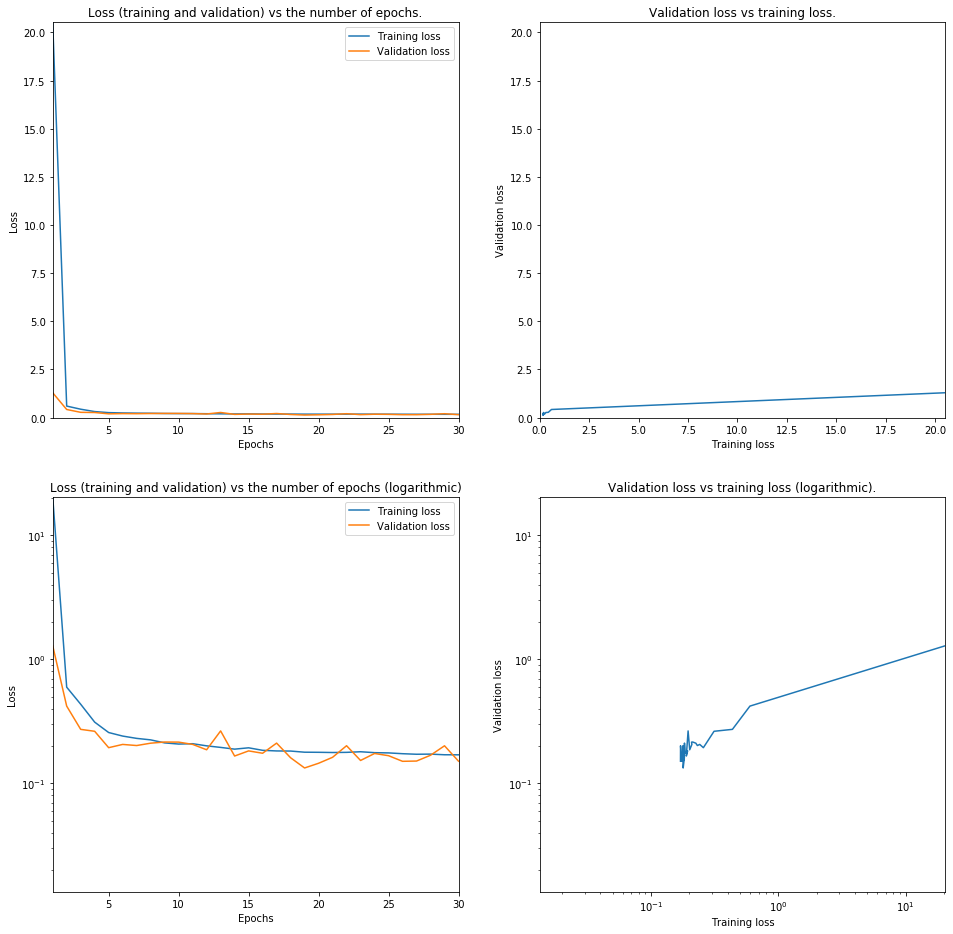

In [38]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
print()

76000/76000 [==============================] - 2s 26us/step
0.15835760797011225


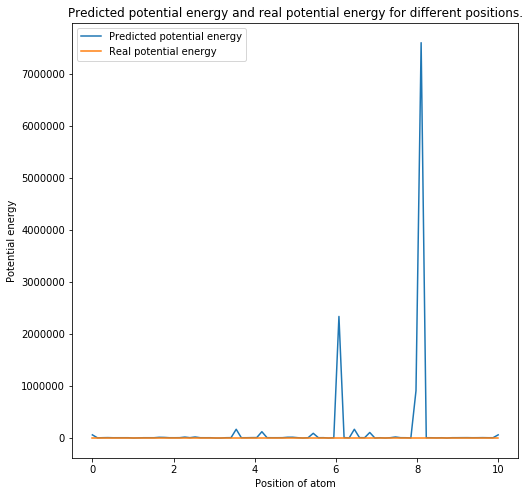

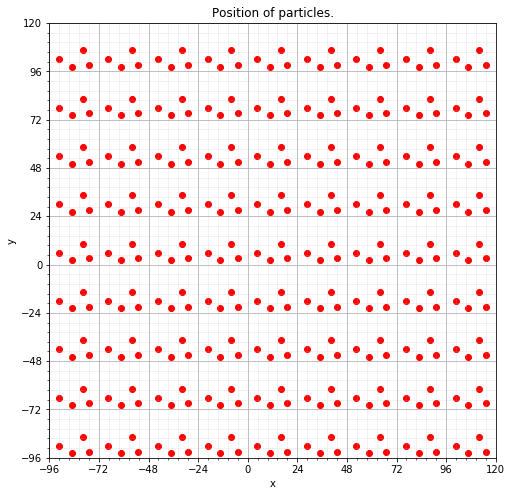

For index 1 Predicted 0.04869721 was 0.0530453436


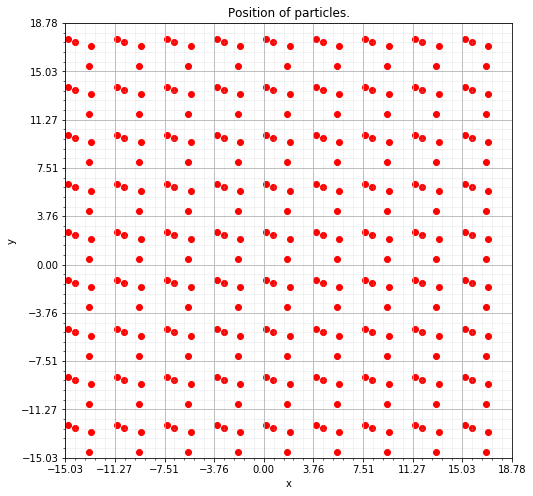

For index 10 Predicted 8.17462 was 5.6725467566


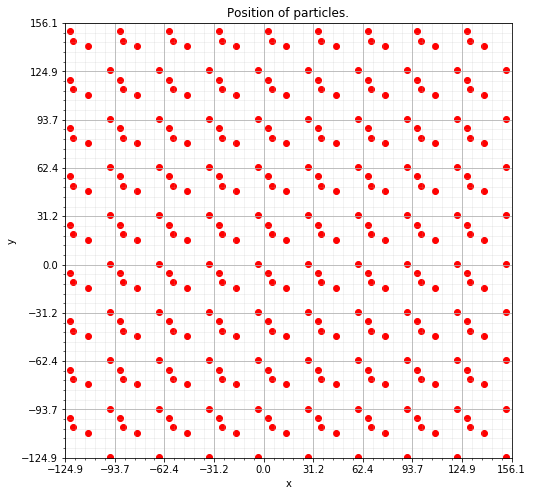

For index 14 Predicted 0.05164964 was 0.053045544300000004


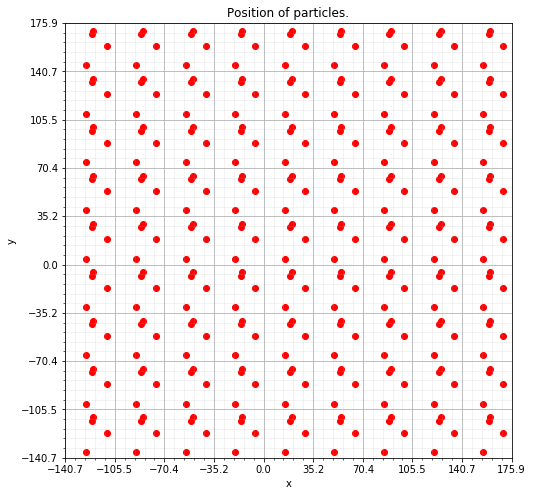

For index 18 Predicted 0.059545442 was 0.053069570700000006


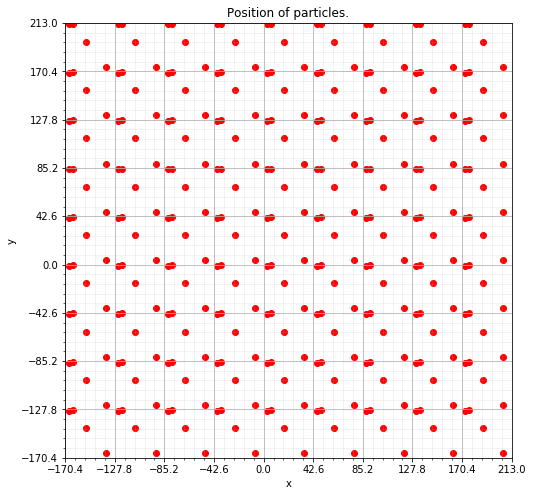

For index 29 Predicted 0.04609039 was 0.053048827800000004


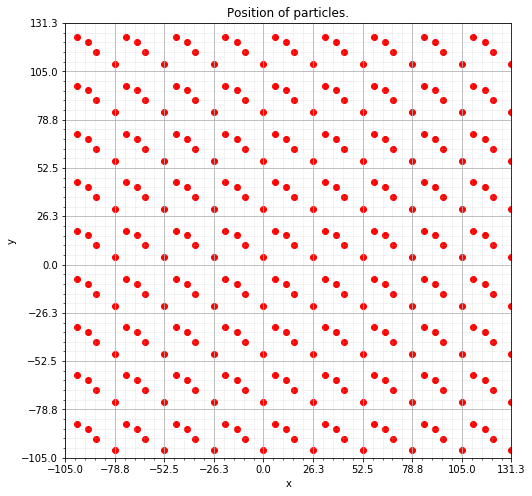

For index 30 Predicted 0.05023193 was 0.0530454834


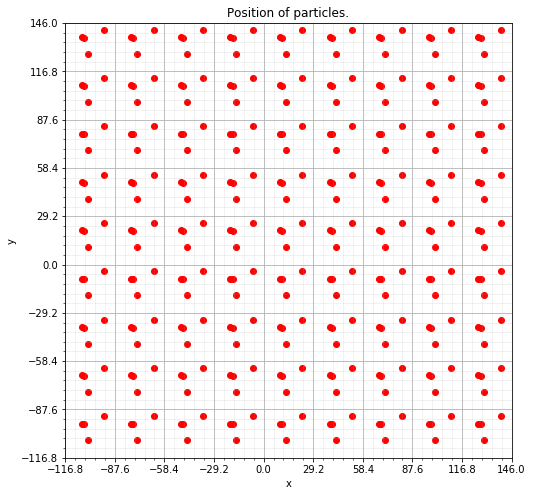

For index 31 Predicted 0.07636041 was 0.0568785371


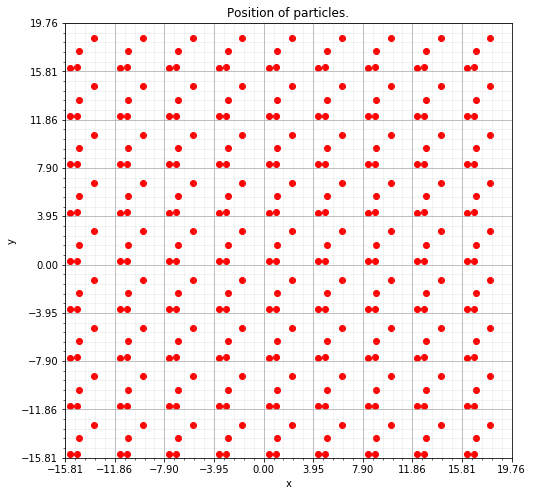

For index 33 Predicted 6.8140817 was 5.9372280024


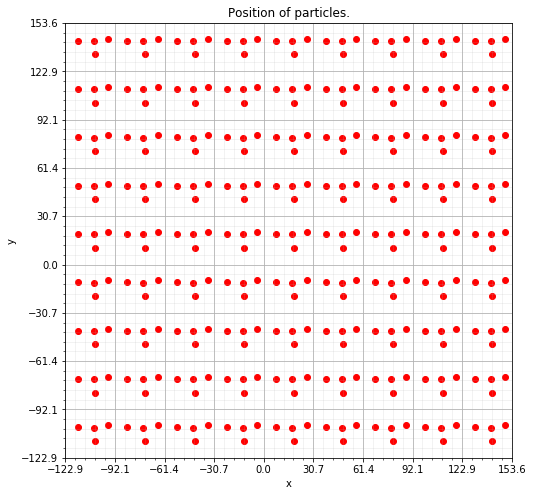

For index 36 Predicted 0.04992575 was 0.0530455349


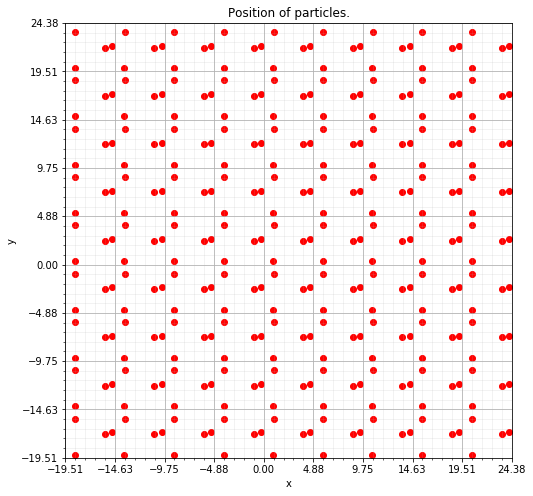

For index 42 Predicted 1.3620257 was 0.9959449529000001



In [39]:
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 2

In [40]:
inputSize = 8
settings = [['Dense', 512, 'softplus', False], ['Dense', 512, 'softplus', False], ['Dense', 512, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               4096      
_________________________________________________________________
activation_20 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262144    
_________________________________________________________________
activation_21 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262144    
_________________________________________________________________
activation_22 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

Train on 212800 samples, validate on 91200 samples
Epoch 1/30
212800/212800 [==============================] - 20s 92us/step - loss: 3.7523 - val_loss: 0.5274
Epoch 2/30
212800/212800 [==============================] - 20s 92us/step - loss: 0.6415 - val_loss: 0.6009
Epoch 3/30
212800/212800 [==============================] - 19s 91us/step - loss: 0.5827 - val_loss: 0.6159
Epoch 4/30
212800/212800 [==============================] - 22s 102us/step - loss: 0.5763 - val_loss: 0.5612
Epoch 5/30
212800/212800 [==============================] - 20s 95us/step - loss: 0.5671 - val_loss: 0.5403
Epoch 6/30
212800/212800 [==============================] - 90s 422us/step - loss: 0.5692 - val_loss: 0.5526
Epoch 7/30
212800/212800 [==============================] - 19s 90us/step - loss: 0.5660 - val_loss: 0.5300
Epoch 8/30
212800/212800 [==============================] - 19s 90us/step - loss: 0.5621 - val_loss: 0.5473
Epoch 9/30
212800/212800 [==============================] - 20s 95us/step - loss: 0

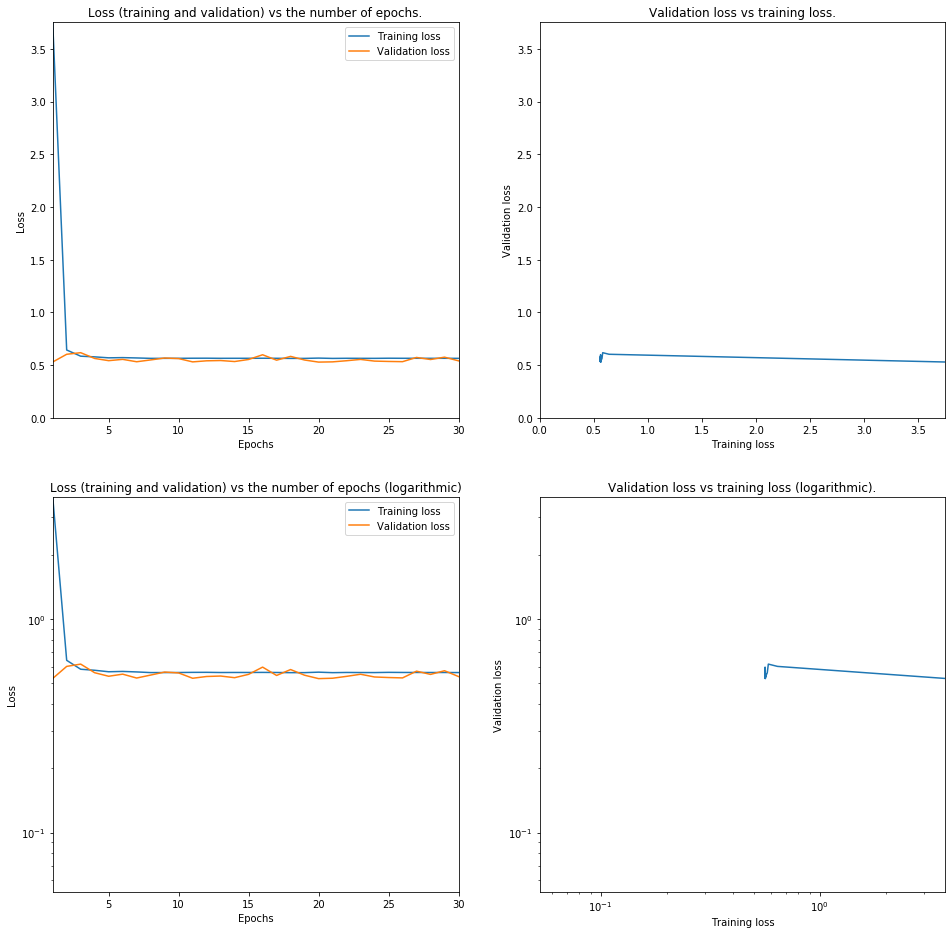

In [41]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
print()

76000/76000 [==============================] - 2s 28us/step
0.5532366215065122


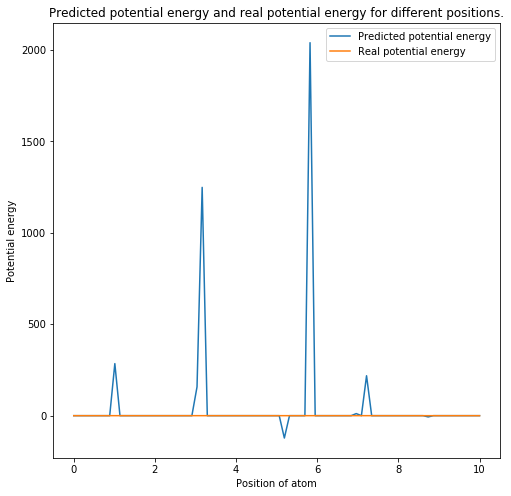

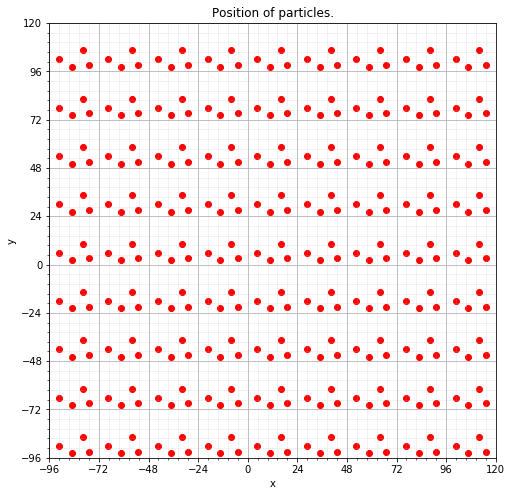

For index 1 Predicted 0.040680557 was 0.0530453436


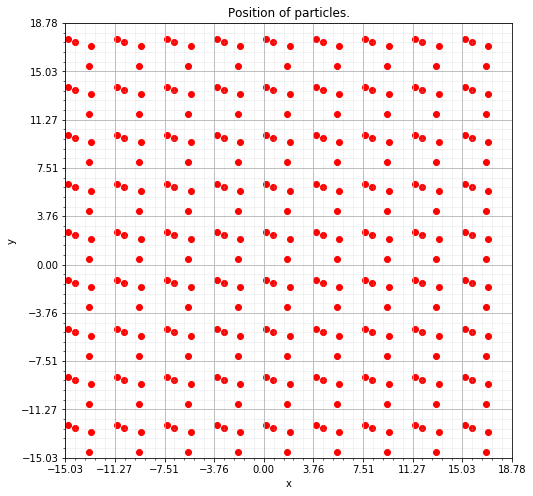

For index 10 Predicted 0.040680557 was 5.6725467566


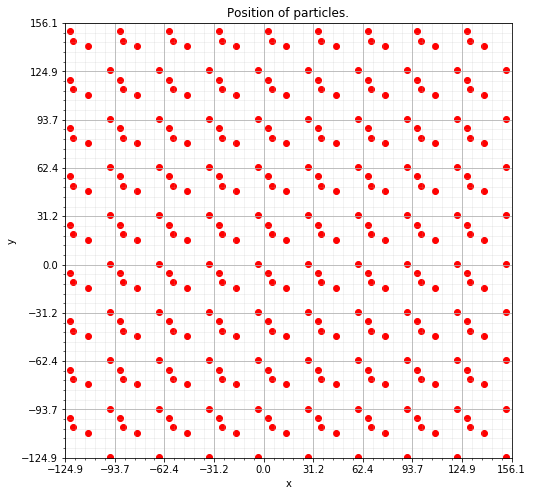

For index 14 Predicted 0.040680557 was 0.053045544300000004


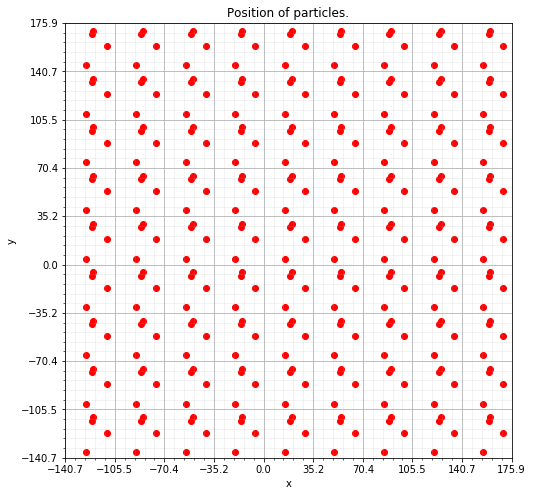

For index 18 Predicted 0.040680557 was 0.053069570700000006


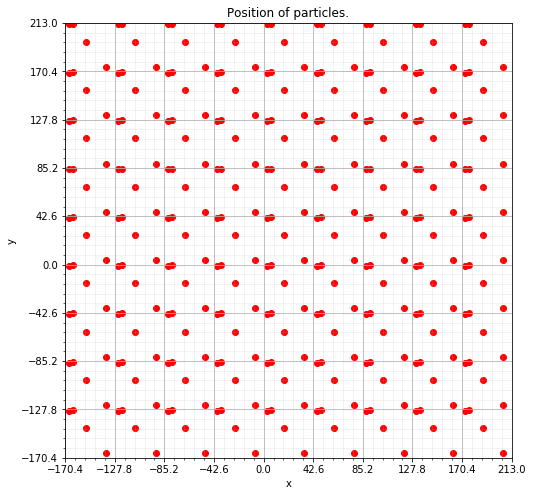

For index 29 Predicted 0.040680557 was 0.053048827800000004


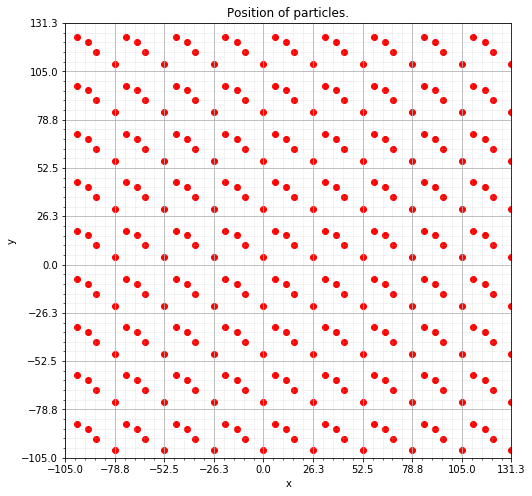

For index 30 Predicted 0.040680557 was 0.0530454834


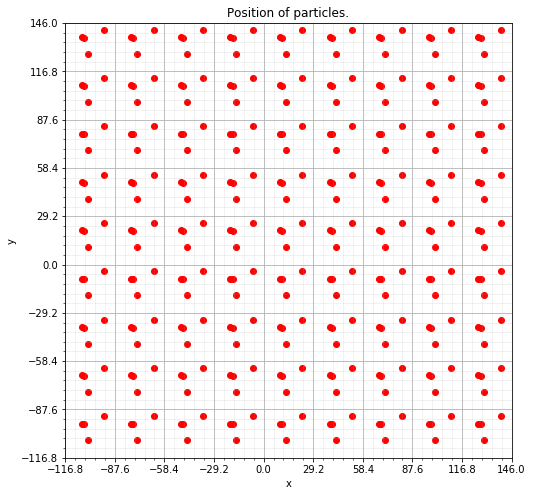

For index 31 Predicted 0.040680557 was 0.0568785371


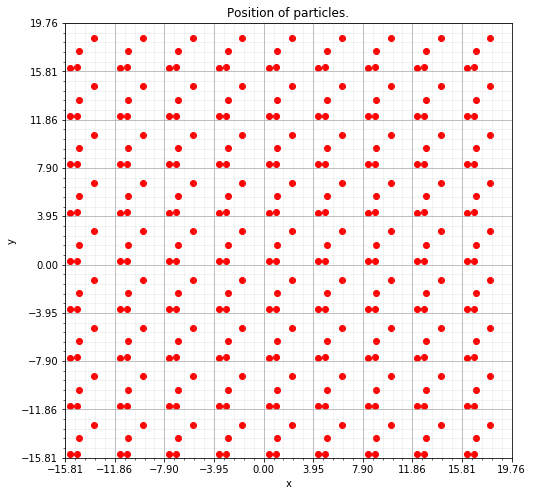

For index 33 Predicted 0.040680557 was 5.9372280024


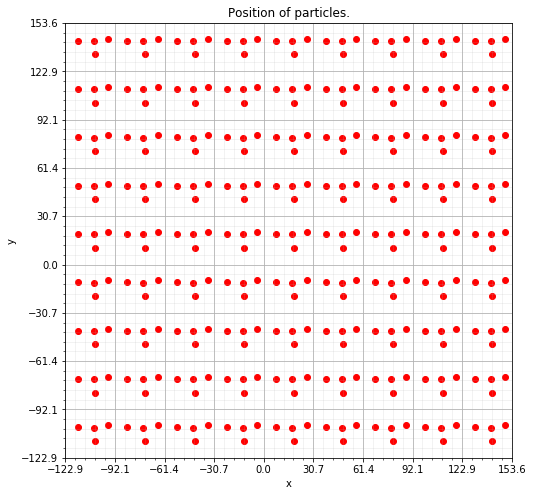

For index 36 Predicted 0.040680557 was 0.0530455349


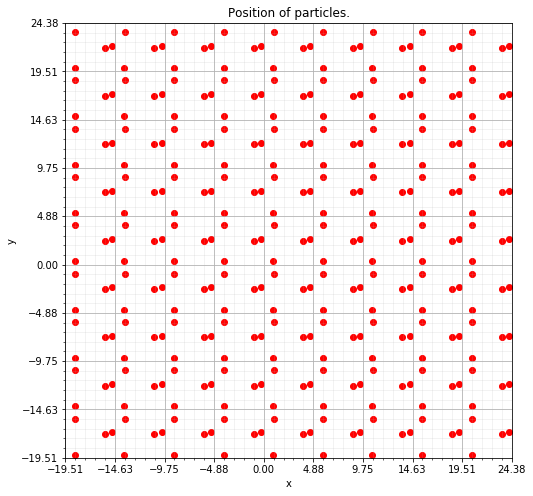

For index 42 Predicted 0.040680557 was 0.9959449529000001



In [42]:
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 3

In [43]:
inputSize = 8
settings = [['Dense', 512, 'softplus', False], ['Dense', 512, 'softplus', False], ['Dense', 512, 'softplus', False], ['Dense', 512, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               4096      
_________________________________________________________________
activation_24 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262144    
_________________________________________________________________
activation_25 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262144    
_________________________________________________________________
activation_26 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

Train on 212800 samples, validate on 91200 samples
Epoch 1/30
212800/212800 [==============================] - 21s 101us/step - loss: 2.1501 - val_loss: 0.5290
Epoch 2/30
212800/212800 [==============================] - 22s 102us/step - loss: 0.5586 - val_loss: 0.5446
Epoch 3/30
212800/212800 [==============================] - 23s 107us/step - loss: 0.5767 - val_loss: 0.5507
Epoch 4/30
212800/212800 [==============================] - 22s 104us/step - loss: 0.5629 - val_loss: 0.5460
Epoch 5/30
212800/212800 [==============================] - 25s 117us/step - loss: 0.5636 - val_loss: 0.5359
Epoch 6/30
212800/212800 [==============================] - 24s 114us/step - loss: 0.5621 - val_loss: 0.5523
Epoch 7/30
212800/212800 [==============================] - 22s 104us/step - loss: 0.5634 - val_loss: 0.5896
Epoch 8/30
212800/212800 [==============================] - 22s 103us/step - loss: 0.5616 - val_loss: 0.5309
Epoch 9/30
212800/212800 [==============================] - 24s 113us/step - 

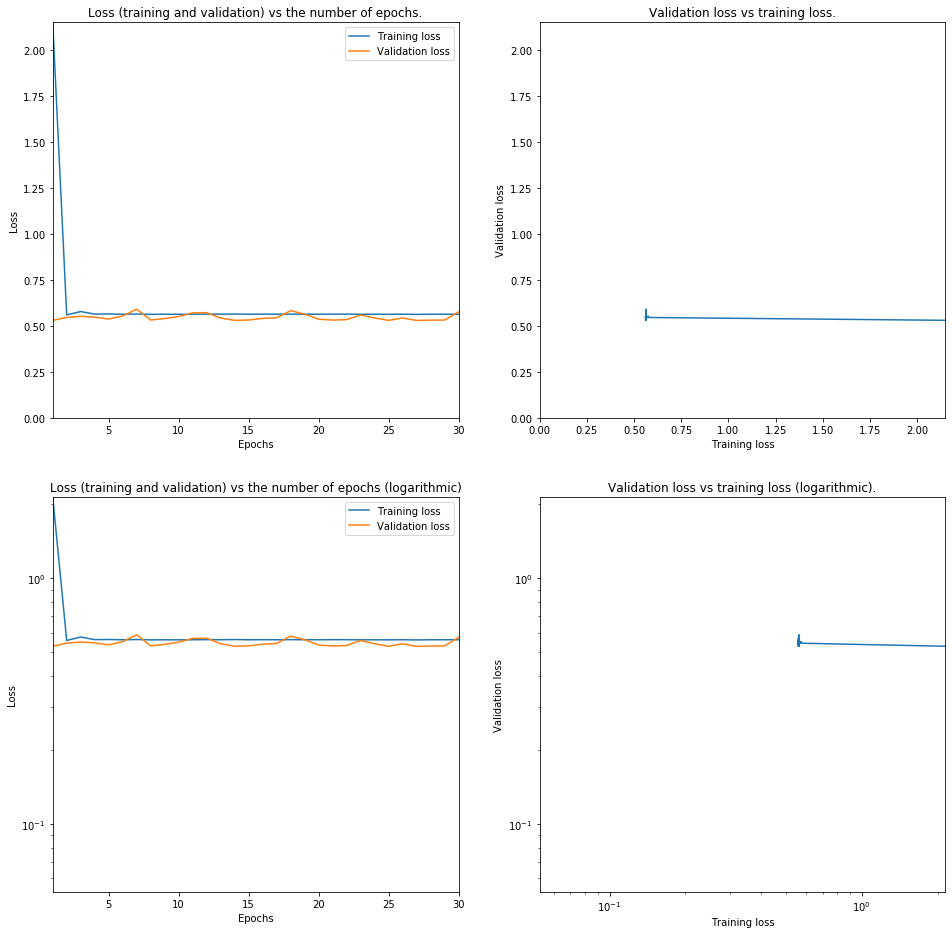

In [44]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
print()

76000/76000 [==============================] - 2s 28us/step
0.5895321896499709


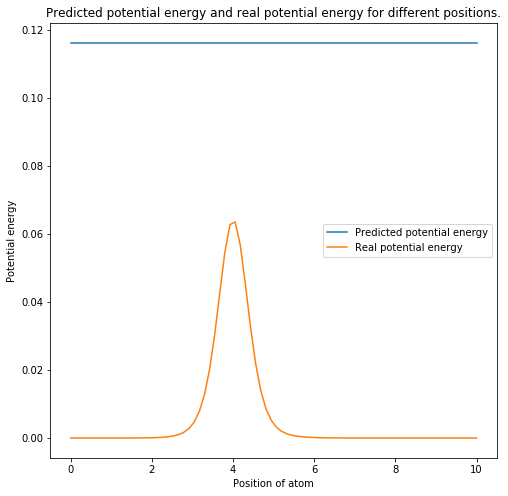

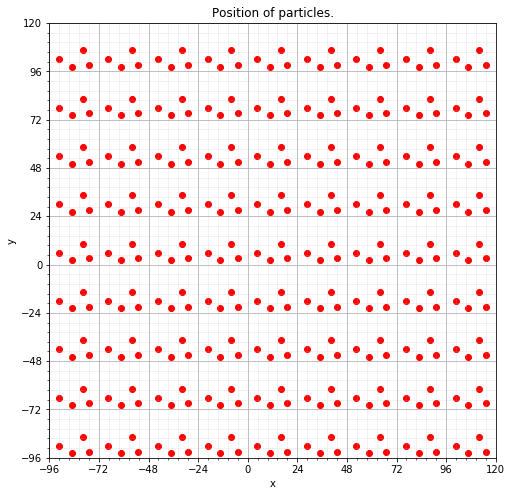

For index 1 Predicted 0.116135664 was 0.0530453436


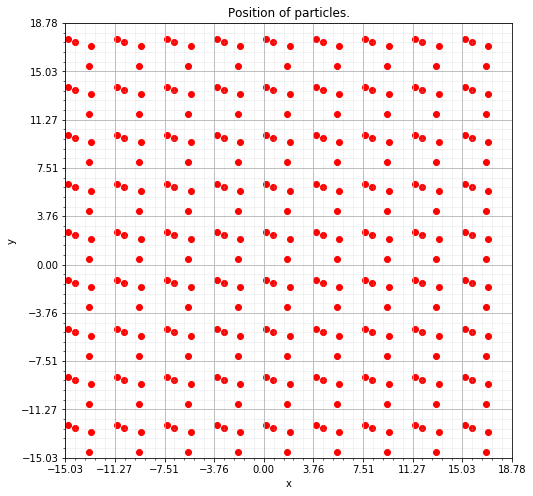

For index 10 Predicted 0.116135664 was 5.6725467566


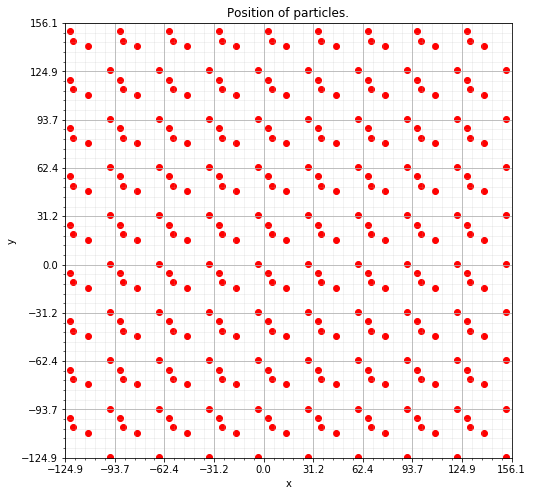

For index 14 Predicted 0.116135664 was 0.053045544300000004


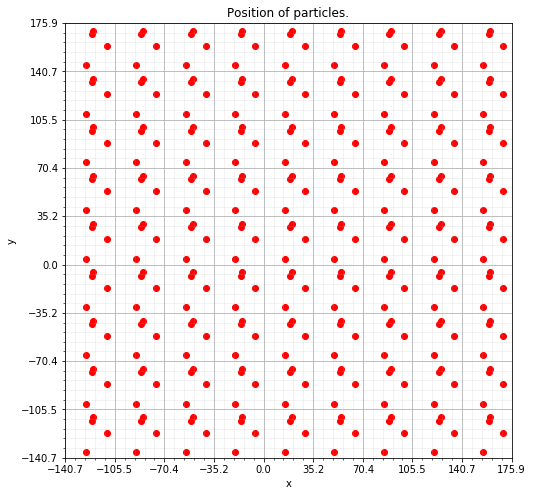

For index 18 Predicted 0.116135664 was 0.053069570700000006


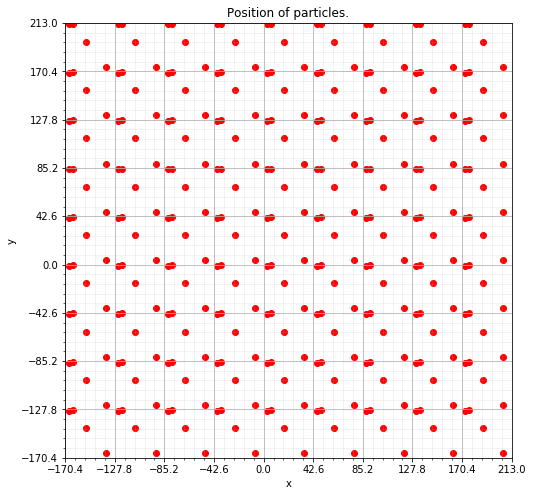

For index 29 Predicted 0.116135664 was 0.053048827800000004


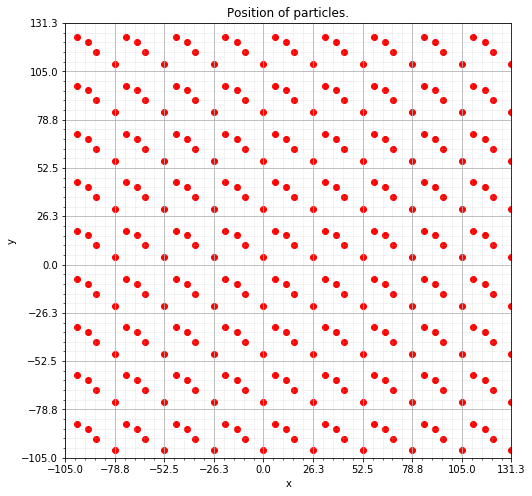

For index 30 Predicted 0.116135664 was 0.0530454834


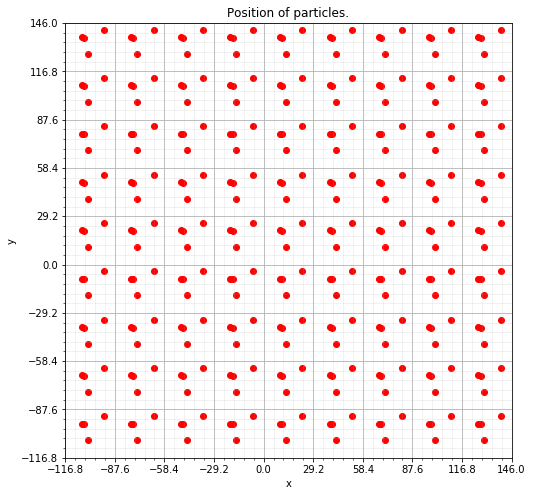

For index 31 Predicted 0.116135664 was 0.0568785371


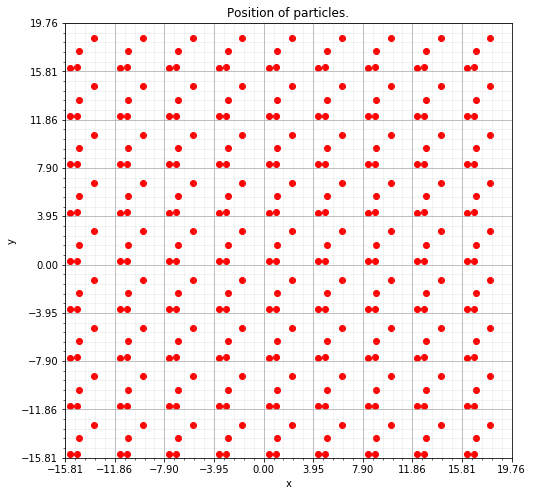

For index 33 Predicted 0.116135664 was 5.9372280024


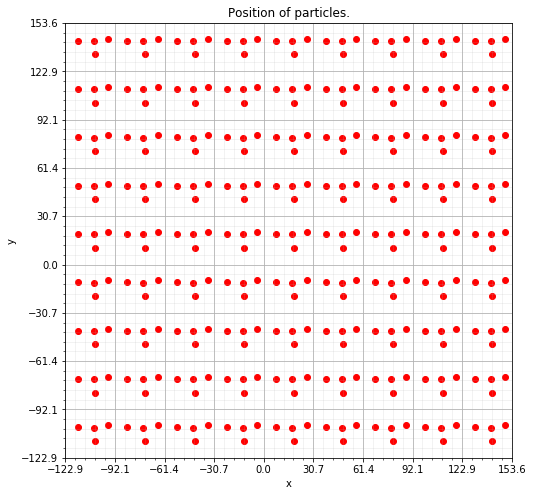

For index 36 Predicted 0.116135664 was 0.0530455349


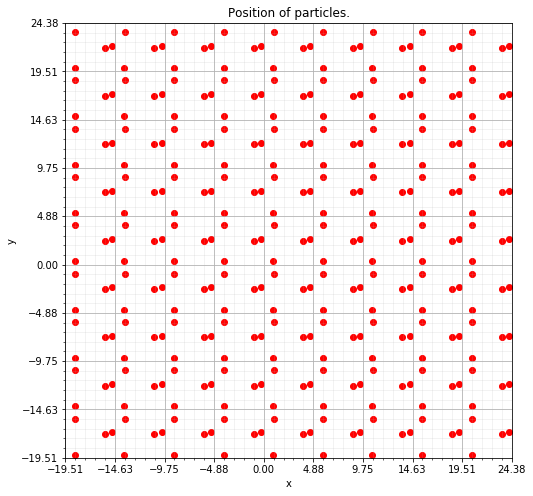

For index 42 Predicted 0.116135664 was 0.9959449529000001



In [45]:
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 4

In [47]:
inputSize = 8
settings = [['Dense', 4096, 'softplus', False], ['Dense', 4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 4096)              32768     
_________________________________________________________________
activation_30 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 4096)              16777216  
_________________________________________________________________
activation_31 (Activation)   (None, 4096)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4096      
_________________________________________________________________
activation_32 (Activation)   (None, 1)                 0         
Total params: 16,814,080
Trainable params: 16,814,080
Non-trainable params: 0
__________________________________________

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
print()

Train on 212800 samples, validate on 91200 samples
Epoch 1/30
212800/212800 [==============================] - 378s 2ms/step - loss: 12.4682 - val_loss: 0.4566
Epoch 2/30
212800/212800 [==============================] - 146s 687us/step - loss: 0.4309 - val_loss: 0.4277
Epoch 3/30
156288/212800 [=====================>........] - ETA: 3:19 - loss: 0.3860

In [ ]:
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 5

In [ ]:
inputSize = 8
settings = [['Dense', 4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
print()

In [ ]:
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 6

In [ ]:
inputSize = 8
settings = [['Dense', 4*4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
print()

In [ ]:
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()